# Plate solve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from scipy.interpolate import interp1d, PchipInterpolator
from sklearn.linear_model import LinearRegression
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS

from image_data import ImageData
from ui.histogram_plot import calc_stretch
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder

import skymap.platesolver as PS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project

### Load and visualize image

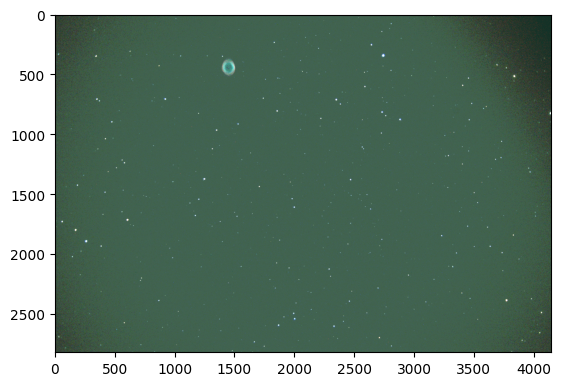

In [2]:
imageData = ImageData(raw=None, fname='refine_20250830_020759.fit', header=None)
hr, hg, hb = imageData.get_deb16_histogram()
a,b = calc_stretch(hr, hg, hb)
gamma_table = np.zeros((256, 3), dtype=np.uint8)
for i in range(3):
    high = max(a[i], b[i])
    low = min(a[i], b[i])
    spline = PchipInterpolator([0, low, high, 256], [0, 0, 255, 256])
    gamma_table[:, i] = spline(np.arange(256))
r = cv2.LUT(imageData.rgb24[:, :, 0], gamma_table[:, 0])
g = cv2.LUT(imageData.rgb24[:, :, 1], gamma_table[:, 1])
b = cv2.LUT(imageData.rgb24[:, :, 2], gamma_table[:, 2])
img_stretched = cv2.cvtColor(np.stack([r, g, b], axis=-1), cv2.COLOR_BGR2RGB)
plt.imshow(img_stretched)

### Set rough location


In [3]:
center = SkyCoord.from_name("M57")
result = {
    'solved': False
}

### Cone search and retrieve stars in the neighborhood

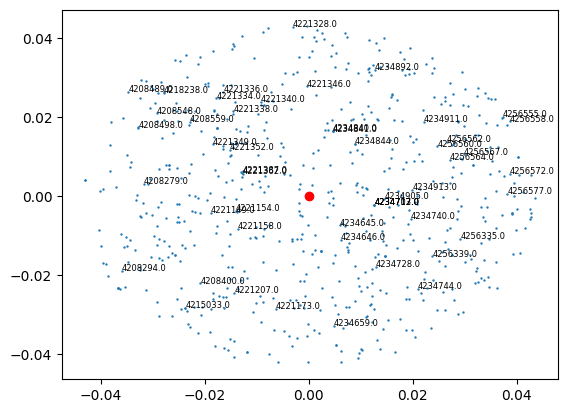

,id,cluster_cx,cluster_cy,ra,dec,mag
0,4234740,0.019677,-0.005801,284.735927,32.689556,3.236923
1,4221387,-0.012773,0.005874,282.519980,33.362669,3.340769
2,4221158,-0.013619,-0.008284,282.470489,32.551060,5.259750
3,4234707,0.012609,-0.002180,284.256708,32.901270,5.430000
4,4256339,0.023748,-0.015240,285.003440,32.145513,5.481625


In [4]:
with SkyMap() as sm:
    df_ref = PS.cone_search_stardata(sm, center, fov_deg=5.0, mag_limit=11.0)

plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy, s=0.5)
for i in range(min(50,len(df_ref))):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')
plt.show()

display(df_ref.head())

### Correllate stars in image to database

In [5]:
df_tgt = imageData.stars
print(f"Num ref stars: {len(df_ref)}, Num tgt stars: {len(df_tgt)}")
result['num_ref'] = len(df_ref)
result['num_tgt'] = len(df_tgt)

fitgaussian2d on 20 images took 0.15 sec; avg: 0.007741 sec
Num ref stars: 666, Num tgt stars: 19


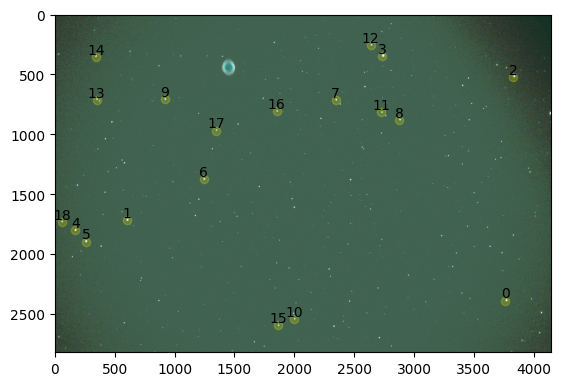

In [6]:
plt.imshow(img_stretched, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2, color='yellow')
for idx, tgt in df_tgt.iterrows():
  plt.text(tgt.cluster_cx, tgt.cluster_cy, idx, va='bottom', ha='center', c='black')
plt.show()


### Match stars in image to database, produce a transform matrix

In [7]:
matcher = StarMatcher()
tx, matcher_result = matcher.matchStarsToTx(df_ref, df_tgt, limit_ref_triangle_fov=1.0)

print(matcher_result)

{'vertex_sorted': True, 'limit_ref_triangle_fov': 1.0, 'ref_triangles': 1832, 'tgt_triangles': 969, 'matches': 3}


### Apply transform to database stars to map them to image frame

In [8]:
result.update(matcher_result)
result['tx'] = tx
df_ref[['img_cx', 'img_cy']] = df_ref.apply(lambda r: pd.Series(np.dot(tx, [r.cluster_cx, r.cluster_cy, 1])).astype(np.int32), axis=1)

display(df_ref)

,id,cluster_cx,cluster_cy,ra,dec,mag,img_cx,img_cy
0,4234740,0.019677,-0.005801,284.735927,32.689556,3.236923,-4100,-4553
1,4221387,-0.012773,0.005874,282.519980,33.362669,3.340769,5693,3300
2,4221158,-0.013619,-0.008284,282.470489,32.551060,5.259750,1457,6233
3,4234707,0.012609,-0.002180,284.256708,32.901270,5.430000,-1632,-3046
4,4256339,0.023748,-0.015240,285.003440,32.145513,5.481625,-7805,-4035
...,...,...,...,...,...,...,...,...
661,4208608,-0.026018,0.015894,281.599356,33.927069,10.991250,11322,5516
662,4259986,0.042615,-0.005847,286.297705,32.660431,10.992500,-8475,-11654
663,4221247,-0.014417,-0.036707,282.433326,30.921738,10.992500,-7217,11841
664,4221426,-0.018126,0.021648,282.139514,34.263374,10.997500,11609,1985


### Transformed database stars in image frame

Those overlapping image can be assigned to stars in image.

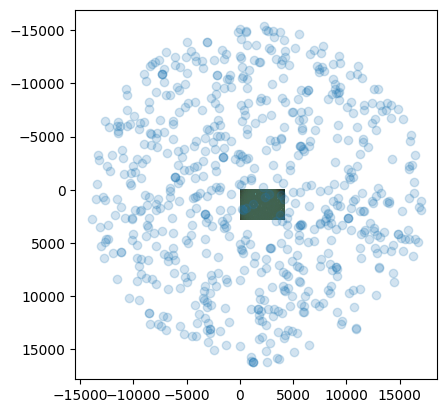

In [9]:
plt.imshow(img_stretched)
plt.scatter(df_ref.img_cx, df_ref.img_cy, alpha=0.2)

### Assign RA & DEC to stars in image

In [10]:
# Reassign stars
def dist(x1,y1, x2,y2):
    return np.sqrt((y2-y1)**2+(x2-x1)**2)

def reassign(t):
    x = df_ref.apply(lambda r: pd.Series([dist(t.cluster_cx, t.cluster_cy, r.img_cx, r.img_cy)]), axis=1)[0]
    m = x.min()
    if m < 25:
      idx = x.argmin()
      return pd.Series([idx, df_ref.iloc[idx].ra, df_ref.iloc[idx].dec])
    else:
      return pd.Series([None, None, None])

df_tgt[['starno', 'ra', 'dec']] = df_tgt.apply(reassign, axis=1)

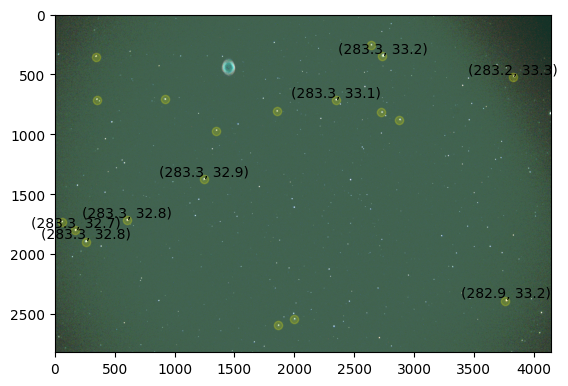

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,ra,dec
0,273,3764.347985,2389.395604,17.000977,18.000977,17.394583,18.008105,"[3746, 2371, 3783, 2408]",619433,9868,7.337609,6.262164,346.0,282.858344,33.180305
1,256,603.492188,1718.062500,18.000977,16.000977,16.261025,20.396669,"[585, 1701, 622, 1736]",445631,7039,7.105840,7.797878,432.0,283.274568,32.811948
2,254,3829.397638,518.377953,15.000977,19.000977,19.323816,16.131538,"[3813, 499, 3846, 538]",135637,2200,23.096166,19.381770,292.0,283.151682,33.342479
3,252,2736.702381,345.579365,15.000977,18.000977,19.966139,16.066948,"[2720, 327, 2753, 364]",89780,1516,6.287396,6.172198,76.0,283.286229,33.210025
4,234,171.440171,1802.286325,15.000977,17.000977,17.871597,17.001008,"[155, 1784, 188, 1821]",467279,7285,24.103172,21.491332,477.0,283.303190,32.746950
5,219,259.525114,1896.164384,15.000977,15.000977,15.746959,17.646818,"[243, 1880, 276, 1913]",491129,7678,7.203119,6.608750,191.0,283.279583,32.751030
6,216,1244.782407,1376.722222,16.000977,15.000977,15.286551,19.491394,"[1227, 1361, 1262, 1392]",356695,5629,5.919202,6.514321,615.0,283.266750,32.925740
7,190,2344.868421,714.852632,14.000977,14.000977,16.375705,14.718885,"[2330, 699, 2359, 730]",186030,2933,4.906549,4.422319,543.0,283.265450,33.127257


In [11]:
plt.imshow(img_stretched, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2, color='yellow')
for idx, tgt in df_tgt.iterrows():
  if not np.isnan(tgt.ra):
    plt.text(tgt.cluster_cx, tgt.cluster_cy, f"({tgt.ra:.1f}, {tgt.dec:.1f})", va='bottom', ha='center', c='black')
plt.show()

display(df_tgt[df_tgt.ra.notna()])

### Regress RA DEC of image center

In [12]:
nonantgt = df_tgt[ (~df_tgt.ra.isna()) & (~df_tgt.dec.isna())]
X = nonantgt[['cluster_cx', 'cluster_cy']]
y = nonantgt[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict(pd.DataFrame([{"cluster_cx": imageData.rgb24.shape[1]//2, "cluster_cy": imageData.rgb24.shape[0]//2}]))[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
separation_arcmin = center.separation(pred_center).arcminute
result['center'] = pred_center
result['separation_arcmin'] = separation_arcmin
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (283.18038302, 33.03373298)>
Separation from target: 10.861430739516305


In [13]:
if center.separation(pred_center).arcminute <= 20:
    
    result['solved'] = True

    df_tgt['name'] = None
    for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
        df_tgt.loc[idx, 'name'] = df_ref.loc[star.starno].id
display(result)

{'solved': True,
 'num_ref': 666,
 'num_tgt': 19,
 'vertex_sorted': True,
 'limit_ref_triangle_fov': 1.0,
 'ref_triangles': 1832,
 'tgt_triangles': 969,
 'matches': 3,
 'tx': array([[-190094.47444131,  310551.44300808,    1441.08482648],
        [-309923.03421942, -188599.60000605,     450.22811006]]),
 'center': <SkyCoord (ICRS): (ra, dec) in deg
     (283.18038302, 33.03373298)>,
 'separation_arcmin': np.float64(10.861430739516305)}

### In one-step:

In [14]:
PS.platesolve(imageData, center)

{'solved': True,
 'num_ref': 666,
 'num_tgt': 19,
 'vertex_sorted': True,
 'limit_ref_triangle_fov': 1.0,
 'ref_triangles': 1832,
 'tgt_triangles': 969,
 'matches': 3,
 'tx': array([[-190094.47444131,  310551.44300808,    1441.08482648],
        [-309923.03421942, -188599.60000605,     450.22811006]]),
 'center': <SkyCoord (ICRS): (ra, dec) in deg
     (283.18038302, 33.03373298)>,
 'separation_arcmin': np.float64(10.861430739516305)}